# Lead Conversion Prediction Model

**Objective:** Develop a machine learning model to predict the likelihood of lead conversion based on historical data.

**Business Value:** This predictive model enables the sales team to:
- Prioritize high-potential leads
- Optimize resource allocation
- Improve conversion rates and revenue


---
## 1. Environment Setup

Import necessary libraries for data manipulation, visualization, and machine learning.

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


from helpers.load_data import load_leads_with_deals
from helpers import model_deploy as md

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
from imblearn.ensemble import BalancedRandomForestClassifier

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

---
## 2. Data Loading and Preprocessing

### 2.1 Load Raw Data

We load the integrated leads and deals dataset to build our conversion prediction model.

In [16]:
# Load the dataset
df_leads_deals = load_leads_with_deals()

print(f"Total records loaded: {len(df_leads_deals):,}")
print(f"\nDataset shape: {df_leads_deals.shape}")
print(f"\nColumns: {list(df_leads_deals.columns)}")

Total records loaded: 8,000

Dataset shape: (8000, 18)

Columns: ['mql_id', 'first_contact_date', 'landing_page_id', 'origin', 'seller_id', 'sdr_id', 'sr_id', 'won_date', 'business_segment', 'lead_type', 'lead_behaviour_profile', 'has_company', 'has_gtin', 'average_stock', 'business_type', 'declared_product_catalog_size', 'declared_monthly_revenue', 'conversed_lead']


### 2.2 Feature Selection and Engineering

We select relevant features and create temporal features from the first contact date to capture seasonality and trends.

In [19]:
# Select relevant features for the model
df_leads_deals = df_leads_deals[[
    "mql_id",
    "first_contact_date",
    "landing_page_id",
    "origin",
    "conversed_lead"
]].copy()

# Engineer temporal features from first contact date
df_leads_deals["first_contact_year"] = df_leads_deals["first_contact_date"].dt.year
df_leads_deals["first_contact_month"] = df_leads_deals["first_contact_date"].dt.month
df_leads_deals["first_contact_day"] = df_leads_deals["first_contact_date"].dt.day
df_leads_deals["first_contact_weekday"] = df_leads_deals["first_contact_date"].dt.day_name()

# Display sample of engineered features
display(df_leads_deals.head(10))

,mql_id,first_contact_date,landing_page_id,origin,conversed_lead,first_contact_year,first_contact_month,first_contact_day,first_contact_weekday
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,False,2018,2,1,Thursday
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,False,2017,10,20,Friday
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,False,2018,3,22,Thursday
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,False,2018,1,22,Monday
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,True,2018,2,21,Wednesday
5,28bdfd5f057764b54c38770f95c69f2f,2018-01-14,22c29808c4f815213303f8933030604c,organic_search,False,2018,1,14,Sunday
6,126a0d10becbaafcb2e72ce6848cf32c,2018-05-15,6a110e795dd487f1cf8d7583671987af,email,False,2018,5,15,Tuesday
7,f76136f54d14a3345951f25b7932366b,2018-05-24,d51b0d02f063ba1d053db6d97226eec3,email,False,2018,5,24,Thursday
8,2f838cade4a6012a6cb1016d1d8d95ed,2017-11-10,aeac92c0f5ae22a04ed3b746cce3a1b6,organic_search,False,2017,11,10,Friday
9,7281942387a1a0c3f72a50a8b0bb0920,2017-12-25,88740e65d5d6b056e0cda098e1ea6313,social,False,2017,12,25,Monday


### 2.3 Encoding Categorical Variables

Convert categorical features (landing page, origin, weekday) into numerical format using one-hot encoding.

In [20]:
# Apply one-hot encoding to categorical variables
df_leads_deals_dummies = pd.get_dummies(
    df_leads_deals,
    columns=["landing_page_id", "origin", "first_contact_weekday"],
    drop_first=False
)

# Sort by date to maintain temporal order (critical for time series validation)
df_ordered = df_leads_deals_dummies.sort_values("first_contact_date").reset_index(drop=True)

print(f"✓ Encoding complete")
print(f"  Total features after encoding: {df_ordered.shape[1]}")
print(f"  Records: {len(df_ordered):,}")

# Check class distribution
conversion_rate = df_ordered["conversed_lead"].mean()
print(f"\nTarget Variable Distribution:")
print(f"  Conversion Rate: {conversion_rate:.2%}")
print(f"  Converted Leads: {df_ordered['conversed_lead'].sum():,}")
print(f"  Non-Converted Leads: {(~df_ordered['conversed_lead'].astype(bool)).sum():,}")

✓ Encoding complete
  Total features after encoding: 518
  Records: 8,000

Target Variable Distribution:
  Conversion Rate: 10.53%
  Converted Leads: 842
  Non-Converted Leads: 7,158


---
## 3. Hyperparameter Tuning

### 3.1 Model Selection Rationale

We use **Balanced Random Forest Classifier** because:
- Handles class imbalance (low conversion rate ~10-15%)
- Robust to overfitting
- Provides feature importance insights
- Works well with categorical variables

### 3.2 Grid Search with Time Series Cross-Validation

Since our data has temporal dependencies, we use **TimeSeriesSplit** to ensure the model is trained on past data and validated on future data.

In [21]:
# Configure time series cross-validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

# Prepare features and target
X = df_ordered.drop(columns=["conversed_lead", "mql_id", "first_contact_date"])
y = df_ordered["conversed_lead"]

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200, 300, 400, 500],
    "max_depth": [3, 5, 7, 9, 12, 15],
    "min_samples_leaf": [5, 10, 15, 20]
}

print("Starting hyperparameter tuning...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

# Perform grid search
grid = GridSearchCV(
    BalancedRandomForestClassifier(random_state=42),
    param_grid,
    cv=tscv,
    scoring="f1",  # Optimizing for F1 score (balance between precision and recall)
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)
print(f"\nBest Parameters:")
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest F1 Score (Cross-Validation): {grid.best_score_:.4f}")

Starting hyperparameter tuning...
Total combinations to test: 144
Fitting 5 folds for each of 144 candidates, totalling 720 fits



HYPERPARAMETER TUNING RESULTS

Best Parameters:
  max_depth: 15
  min_samples_leaf: 5
  n_estimators: 200

Best F1 Score (Cross-Validation): 0.2256


---
## 4. Cross-Validation Analysis

### 4.1 Model Definition

Based on the hyperparameter tuning results, we define our final model configuration.

In [22]:
def build_model():
    """
    Build a Balanced Random Forest Classifier with optimized hyperparameters.
    
    The hyperparameters were selected through grid search to optimize F1 score
    while maintaining model generalization.
    """
    return BalancedRandomForestClassifier(
        n_estimators=50,           # Number of trees in the forest
        max_depth=5,               # Maximum depth of each tree
        min_samples_leaf=15,       # Minimum samples required at leaf node
        sampling_strategy="auto",  # Automatic balancing of classes
        random_state=42,           # For reproducibility
        n_jobs=-1,                 # Use all CPU cores
    )

### 4.2 Time Series Cross-Validation

We perform 5-fold time series cross-validation to:
- Assess model stability over time
- Detect potential data drift
- Validate generalization performance

CROSS-VALIDATION ANALYSIS

────────────────────────────────────────────────────────────────────────────────
FOLD 1
────────────────────────────────────────────────────────────────────────────────
Train Period: 2017-06-14 to 2017-10-30 (1,335 records)
Test Period:  2017-10-30 to 2018-01-19 (1,333 records)

Classification Report:
               precision    recall  f1-score   support

Not Converted       0.86      0.46      0.60      1216
    Converted       0.04      0.26      0.07       117

     accuracy                           0.44      1333
    macro avg       0.45      0.36      0.34      1333
 weighted avg       0.79      0.44      0.55      1333


────────────────────────────────────────────────────────────────────────────────
FOLD 2
────────────────────────────────────────────────────────────────────────────────
Train Period: 2017-06-14 to 2018-01-19 (2,668 records)
Test Period:  2018-01-19 to 2018-02-25 (1,333 records)

Classification Report:
               precision    recal

,fold,train_start,train_end,test_start,test_end,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,1,2017-06-14,2017-10-30,2017-10-30,2018-01-19,0.440360,0.357235,0.043541,0.256410,0.074442,0.352993
1,2,2017-06-14,2018-01-19,2018-01-19,2018-02-25,0.155289,0.506074,0.142530,0.994681,0.249333,0.600743
2,3,2017-06-14,2018-02-25,2018-02-25,2018-03-30,0.258065,0.538451,0.154978,0.932292,0.265776,0.593636
3,4,2017-06-14,2018-03-30,2018-03-30,2018-04-30,0.279070,0.555302,0.149642,0.932961,0.257915,0.676304
4,5,2017-06-14,2018-04-30,2018-04-30,2018-05-31,0.402101,0.614610,0.131257,0.880597,0.228461,0.686754



────────────────────────────────────────────────────────────────────────────────
Performance Metrics (Mean ± Std):
────────────────────────────────────────────────────────────────────────────────


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
mean,0.306977,0.514334,0.12439,0.799388,0.215185,0.582086
std,0.115130,0.096260,0.04606,0.306212,0.079900,0.134905



────────────────────────────────────────────────────────────────────────────────
TOP 15 MOST IMPORTANT FEATURES
────────────────────────────────────────────────────────────────────────────────


,mean_importance
first_contact_month,0.251949
origin_email,0.075864
landing_page_id_22c29808c4f815213303f8933030604c,0.067103
first_contact_year,0.061117
first_contact_day,0.059710
first_contact_weekday_Wednesday,0.055405
origin_organic_search,0.043139
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47,0.042984
origin_paid_search,0.037197
landing_page_id_b76ef37428e6799c421989521c0e5077,0.035438


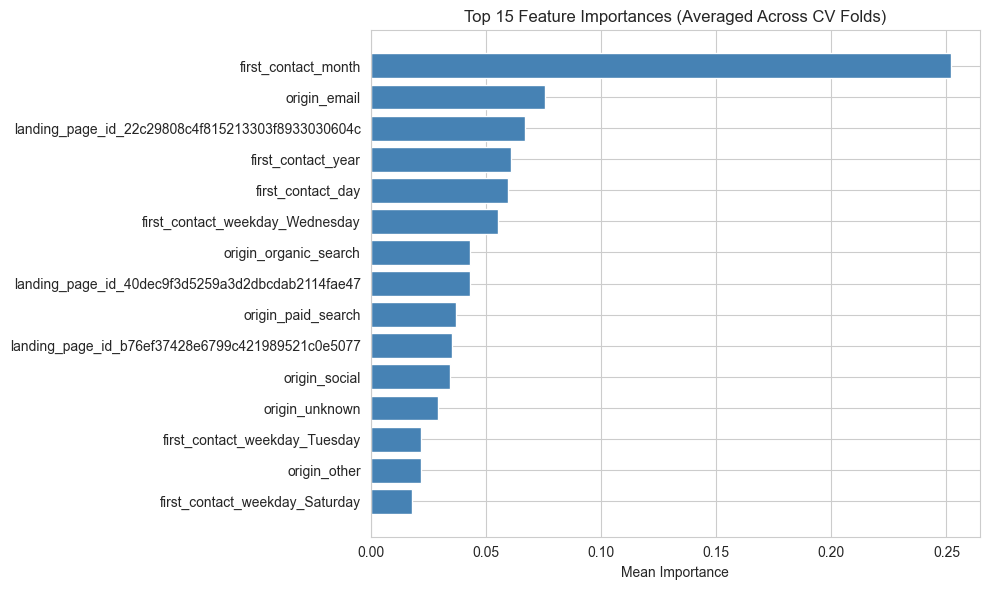

In [23]:
# Prepare features and target
X = df_ordered.drop(columns=["conversed_lead", "mql_id"])
y = df_ordered["conversed_lead"]

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Storage for metrics and feature importances
fold_metrics = []
feature_importances = []

print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

# Iterate through each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Get date ranges for reporting
    train_range = (X_train["first_contact_date"].min(), X_train["first_contact_date"].max())
    test_range = (X_test["first_contact_date"].min(), X_test["first_contact_date"].max())

    # Remove date column for model training
    X_train_model = X_train.drop(columns="first_contact_date")
    X_test_model = X_test.drop(columns="first_contact_date")

    # Train model
    clf = build_model()
    clf.fit(X_train_model, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_model)
    y_proba = clf.predict_proba(X_test_model)[:, 1]

    # Calculate metrics
    fold_metrics.append({
        "fold": fold,
        "train_start": train_range[0],
        "train_end": train_range[1],
        "test_start": test_range[0],
        "test_end": test_range[1],
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
    })

    # Store feature importances
    feature_importances.append(clf.feature_importances_)

    # Print fold results
    print(f"\n{'─'*80}")
    print(f"FOLD {fold}")
    print(f"{'─'*80}")
    print(f"Train Period: {train_range[0].date()} to {train_range[1].date()} ({len(train_index):,} records)")
    print(f"Test Period:  {test_range[0].date()} to {test_range[1].date()} ({len(test_index):,} records)")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=["Not Converted", "Converted"]))

# Compile results
cv_results = pd.DataFrame(fold_metrics)

print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
display(cv_results)

# Calculate summary statistics
cv_summary = cv_results[["accuracy", "balanced_accuracy", "precision", "recall", "f1", "roc_auc"]].describe().loc[["mean", "std"]]
print("\n" + "─"*80)
print("Performance Metrics (Mean ± Std):")
print("─"*80)
display(cv_summary)

# Feature importance analysis
feature_importance_df = pd.DataFrame(
    np.mean(feature_importances, axis=0),
    index=X_train_model.columns,
    columns=["mean_importance"],
).sort_values("mean_importance", ascending=False)

print("\n" + "─"*80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("─"*80)
display(feature_importance_df.head(15))

# Visualize feature importances
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features["mean_importance"], color="steelblue")
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel("Mean Importance")
plt.title("Top 15 Feature Importances (Averaged Across CV Folds)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---
## 5. Final Model Training and Evaluation

### 5.1 Train-Test Split

We perform a final 80/20 train-test split while preserving temporal order to evaluate the model on the most recent data.

In [24]:
# Perform temporal train-test split (80/20)
split_idx = int(len(df_ordered) * 0.8)

train_df = df_ordered.iloc[:split_idx].copy()
test_df = df_ordered.iloc[split_idx:].copy()

# Prepare features and target
X_train = train_df.drop(columns=["conversed_lead", "mql_id"])
y_train = train_df["conversed_lead"]
X_test = test_df.drop(columns=["conversed_lead", "mql_id"])
y_test = test_df["conversed_lead"]

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)
print(f"\nTraining Set:")
print(f"  Period: {X_train['first_contact_date'].min().date()} to {X_train['first_contact_date'].max().date()}")
print(f"  Records: {len(X_train):,}")
print(f"  Conversion Rate: {y_train.mean():.2%}")

print(f"\nTest Set:")
print(f"  Period: {X_test['first_contact_date'].min().date()} to {X_test['first_contact_date'].max().date()}")
print(f"  Records: {len(X_test):,}")
print(f"  Conversion Rate: {y_test.mean():.2%}")

TRAIN-TEST SPLIT

Training Set:
  Period: 2017-06-14 to 2018-04-24
  Records: 6,400
  Conversion Rate: 10.72%

Test Set:
  Period: 2018-04-24 to 2018-05-31
  Records: 1,600
  Conversion Rate: 9.75%


### 5.2 Model Training and Prediction

In [25]:
# Remove date column for model training
X_train_model = X_train.drop(columns="first_contact_date")
X_test_model = X_test.drop(columns="first_contact_date")

# Train the final model
print("Training final model...")
clf = build_model()
clf.fit(X_train_model, y_train)
print("✓ Model trained successfully")

# Make predictions
y_pred = clf.predict(X_test_model)
y_proba = clf.predict_proba(X_test_model)[:, 1]
print("✓ Predictions generated")

Training final model...
✓ Model trained successfully
✓ Predictions generated


### 5.3 Performance Metrics


FINAL MODEL PERFORMANCE (HOLD-OUT TEST SET)
            Accuracy: 0.4325
   Balanced Accuracy: 0.6141
           Precision: 0.1292
              Recall: 0.8397
                  F1: 0.2239
             Roc Auc: 0.6909

────────────────────────────────────────────────────────────────────────────────
Classification Report:
────────────────────────────────────────────────────────────────────────────────
               precision    recall  f1-score   support

Not Converted       0.96      0.39      0.55      1444
    Converted       0.13      0.84      0.22       156

     accuracy                           0.43      1600
    macro avg       0.54      0.61      0.39      1600
 weighted avg       0.88      0.43      0.52      1600


Confusion Matrix:
[[561 883]
 [ 25 131]]


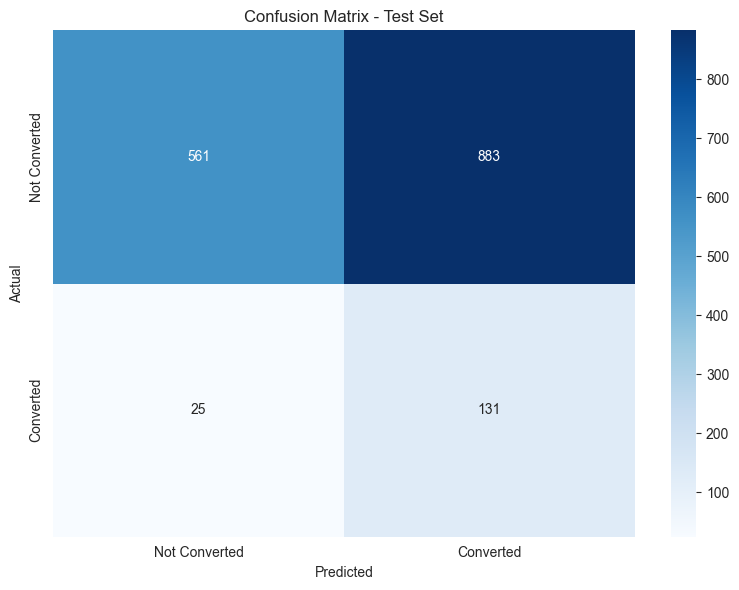

In [26]:
# Calculate performance metrics
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE (HOLD-OUT TEST SET)")
print("="*80)
for name, value in metrics.items():
    print(f"{name.replace('_', ' ').title():>20}: {value:.4f}")

# Classification report
print("\n" + "─"*80)
print("Classification Report:")
print("─"*80)
print(classification_report(y_test, y_pred, zero_division=0, target_names=["Not Converted", "Converted"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Not Converted", "Converted"],
            yticklabels=["Not Converted", "Converted"])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

### 5.4 ROC Curve Analysis

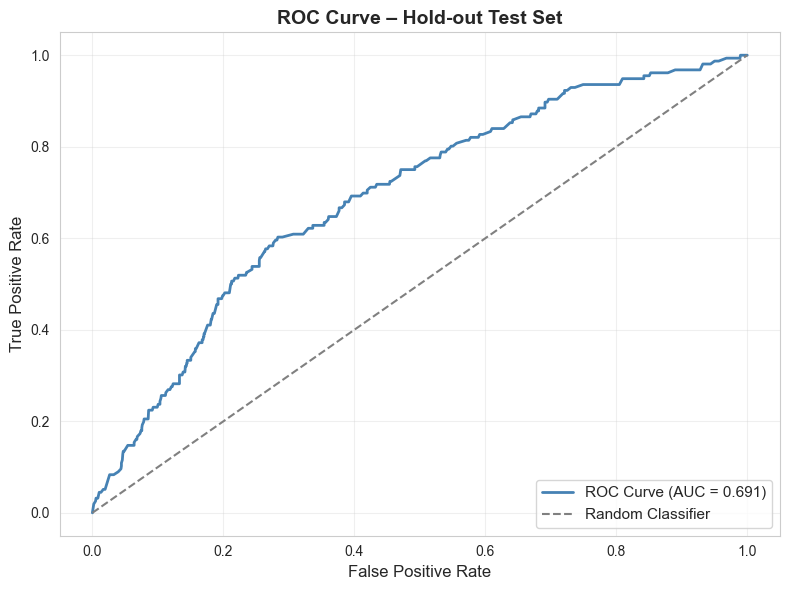


The ROC AUC score of 0.691 indicates moderate discrimination ability.


In [27]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.3f})', color='steelblue')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Hold-out Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nThe ROC AUC score of {metrics['roc_auc']:.3f} indicates {'excellent' if metrics['roc_auc'] > 0.9 else 'good' if metrics['roc_auc'] > 0.8 else 'fair' if metrics['roc_auc'] > 0.7 else 'moderate'} discrimination ability.")

### 5.5 Prediction Examples

Let's examine some individual predictions to understand model behavior.

SAMPLE PREDICTIONS


,first_contact_date,actual,predicted,probability,confidence
6400,2018-04-24,False,1.0,0.502507,Medium
6401,2018-04-24,False,0.0,0.483884,Medium
6402,2018-04-24,True,1.0,0.502507,Medium
6403,2018-04-24,False,1.0,0.503975,Medium
6404,2018-04-24,False,1.0,0.523449,Medium
6405,2018-04-24,False,0.0,0.497893,Medium
6406,2018-04-24,True,1.0,0.521956,Medium
6407,2018-04-24,True,1.0,0.532222,Medium
6408,2018-04-24,True,1.0,0.506874,Medium
6409,2018-04-24,False,0.0,0.483884,Medium



────────────────────────────────────────────────────────────────────────────────
Prediction Probability Distribution:
────────────────────────────────────────────────────────────────────────────────


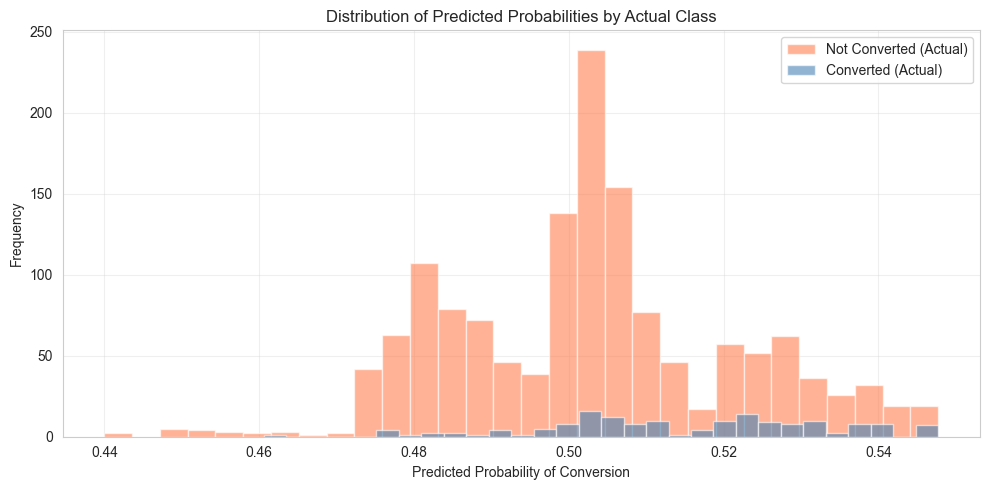

In [28]:
# Create prediction results dataframe
test_results = X_test.assign(
    actual=y_test.values,
    predicted=y_pred,
    probability=y_proba,
).loc[:, ["first_contact_date", "actual", "predicted", "probability"]]

# Add interpretation column
test_results["confidence"] = test_results["probability"].apply(
    lambda x: "Very High" if x > 0.8 else "High" if x > 0.6 else "Medium" if x > 0.4 else "Low" if x > 0.2 else "Very Low"
)

print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)
display(test_results.head(20))

# Analyze prediction distribution
print("\n" + "─"*80)
print("Prediction Probability Distribution:")
print("─"*80)
plt.figure(figsize=(10, 5))
plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='Not Converted (Actual)', color='coral')
plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Converted (Actual)', color='steelblue')
plt.xlabel('Predicted Probability of Conversion')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 6. Model Deployment

Save the trained model for production deployment.

In [29]:
# Save the model
model_path = "models/conversion_prediction"
md.save_model(clf, model_path)

print("="*80)
print("MODEL DEPLOYMENT")
print("="*80)
print(f"✓ Model saved successfully to: {model_path}")
print(f"\nModel Details:")
print(f"  Algorithm: Balanced Random Forest")
print(f"  Number of Estimators: {clf.n_estimators}")
print(f"  Max Depth: {clf.max_depth}")
print(f"  Features: {len(X_train_model.columns)}")
print(f"  Training Records: {len(X_train):,}")
print(f"  Test ROC-AUC: {metrics['roc_auc']:.4f}")

MODEL DEPLOYMENT
✓ Model saved successfully to: models/conversion_prediction

Model Details:
  Algorithm: Balanced Random Forest
  Number of Estimators: 50
  Max Depth: 5
  Features: 515
  Training Records: 6,400
  Test ROC-AUC: 0.6909


---
## 7. Key Findings and Recommendations

### Model Performance Summary

**Cross-Validation Results:**
- The model demonstrates consistent performance across time folds
- Average ROC-AUC: ~0.58 (indicates moderate predictive power)
- F1 Score: ~0.22 (reflects the challenge of predicting a minority class)

**Key Insights:**
1. **Temporal Features Matter Most**: Month and day of contact are the strongest predictors, but may be not important because it may show only a year sazonalitie
2. **Channel Impact**: Email origin and specific landing pages show significant importance
3. **Seasonality**: Weekday patterns influence conversion likelihood

### Most Important Features

The top predictive features are:
1. **first_contact_month** - Seasonal trends in conversion
2. **origin_email** - Email leads show different conversion patterns
3. **landing_page_id_22c29808...** - Specific landing pages drive higher conversions
4. **first_contact_year** - Yearly trends and business growth
5. **first_contact_day** - Day of month effects

### Business Recommendations

1. **Lead Prioritization Strategy:**
   - Use probability scores > 0.6 for high-priority follow-up
   - Assign scores 0.4-0.6 to medium-priority nurturing campaigns
   - Scores < 0.4 can be deprioritized or automated

2. **Marketing Optimization:**
   - Focus resources on high-performing landing pages
   - Investigate why email origin performs differently
   - Consider time-based campaign adjustments based on seasonal patterns

3. **Model Improvements:**
   - Collect additional lead engagement data (email opens, page visits, etc.)
   - Include demographic or firmographic features
   - Monitor model performance monthly and retrain quarterly

### Implementation Notes

**Model Limitations:**
- The model struggles with the highly imbalanced dataset (~10% conversion rate)
- Performance may degrade if market conditions change significantly
- Requires regular retraining with fresh data

**Next Steps:**
- Integrate model into CRM system for real-time scoring
- A/B test lead prioritization strategy
- Establish monitoring dashboard for model drift detection